In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import matplotlib as mpl
import ground_motion_qh
from ground_motion_qh.earthquake import EarthquakeCatalog
import os
from pathlib import Path
base_dir = Path(ground_motion_qh.__file__).parent.parent

mpl.rcParams['figure.dpi'] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
download_name = "ANZA_SND_1994_M4"
data_dir = base_dir / "data" / "raw_data" / download_name

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

metadata = np.load(data_dir / "metadata.npy", allow_pickle=True).item()

In [14]:
earthquakes = EarthquakeCatalog(
    filename=data_dir / "local_catalog.csv",
    kwargs=metadata["earthquake_metadata"],
)

/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/ground_motion_qh/earthquake.py:218: UserWarning: Using existing /Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/data/raw_data/ANZA_SND_1994_M4/local_catalog.csv
  warnings.warn(f"Using existing {filename}")


<Axes: xlabel='Time', ylabel='mag'>

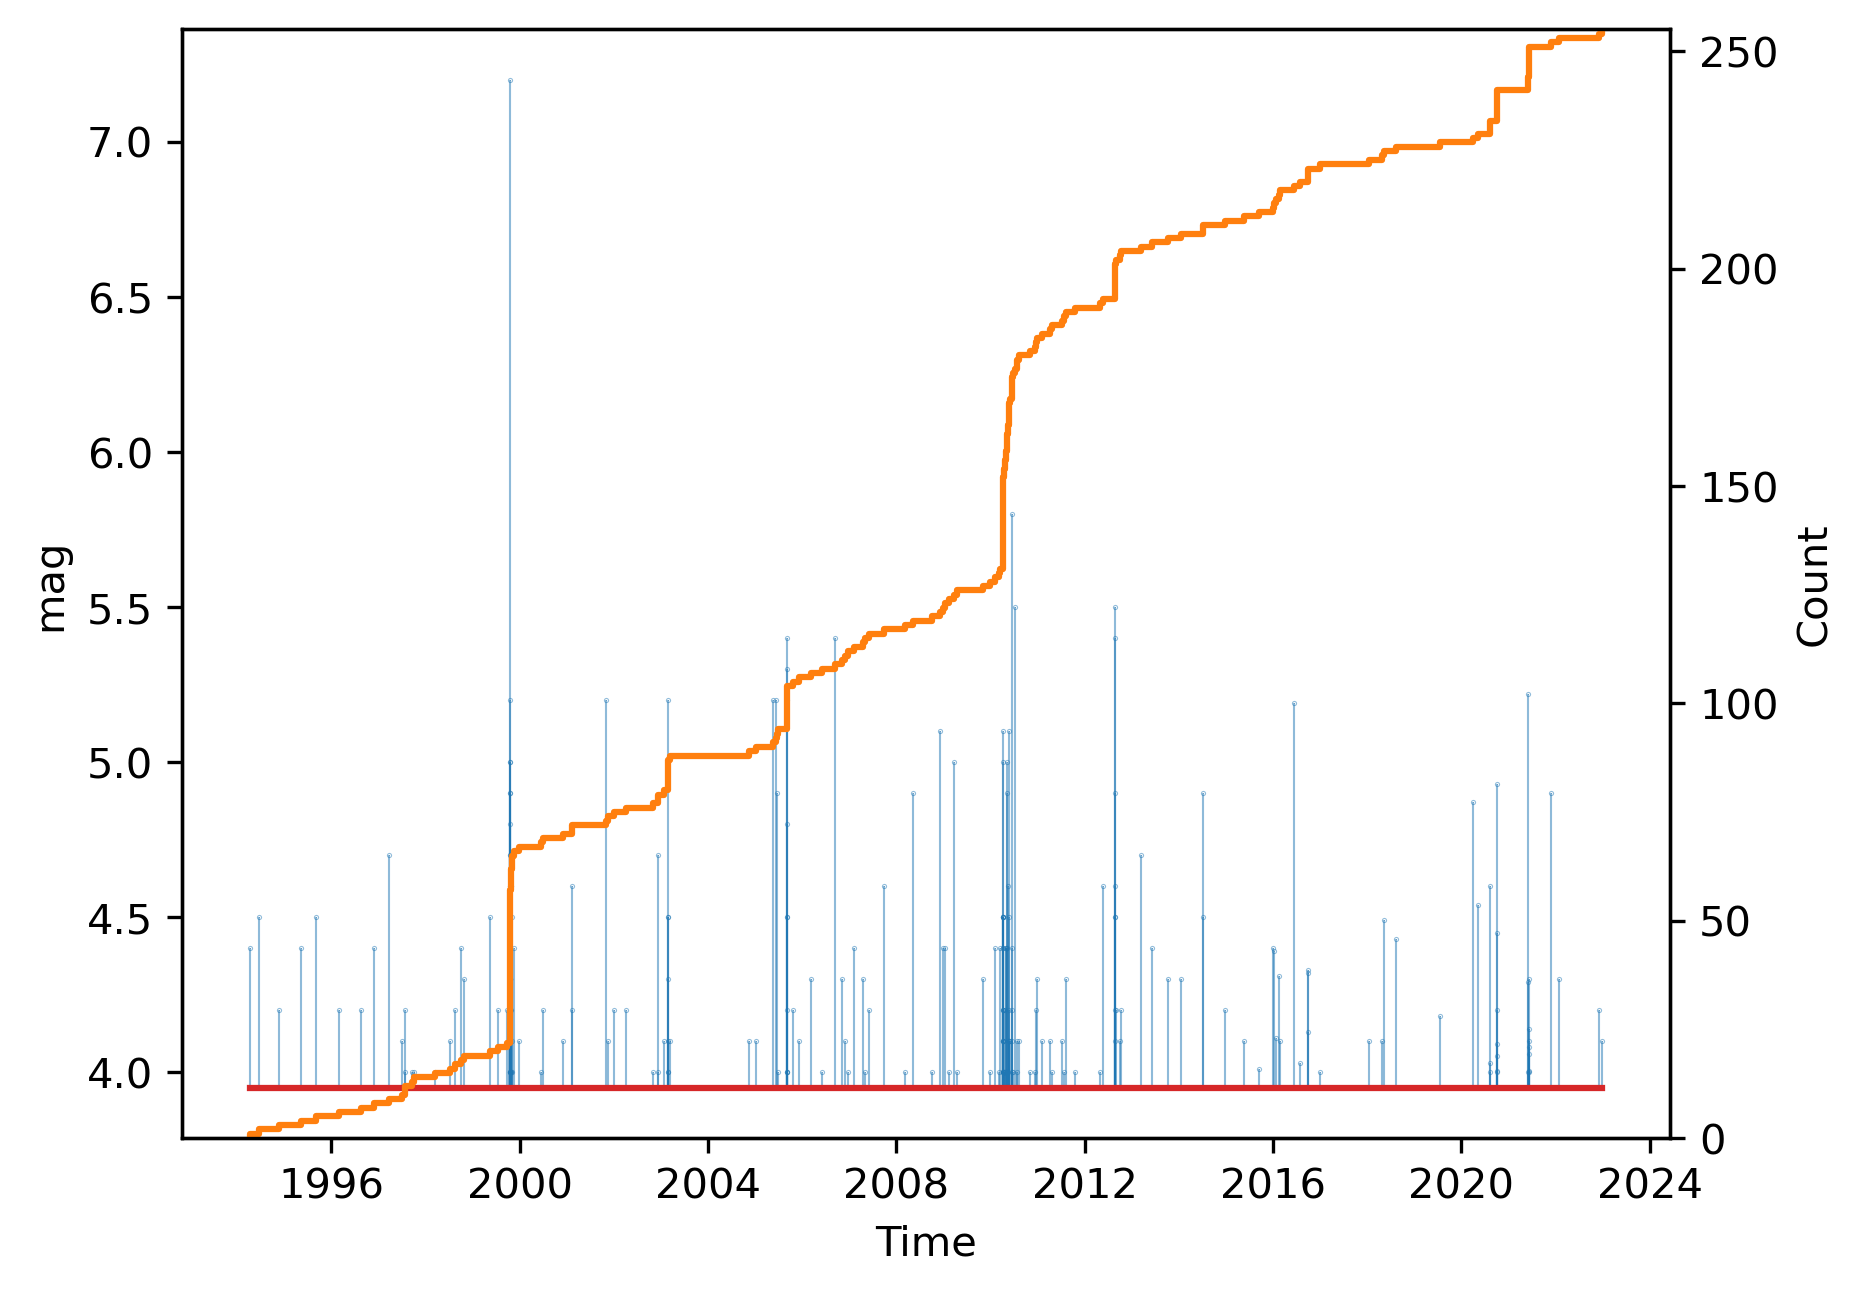

In [5]:
earthquakes.plot_time_series()

<GeoAxes: xlabel='Longitude', ylabel='Latitude'>

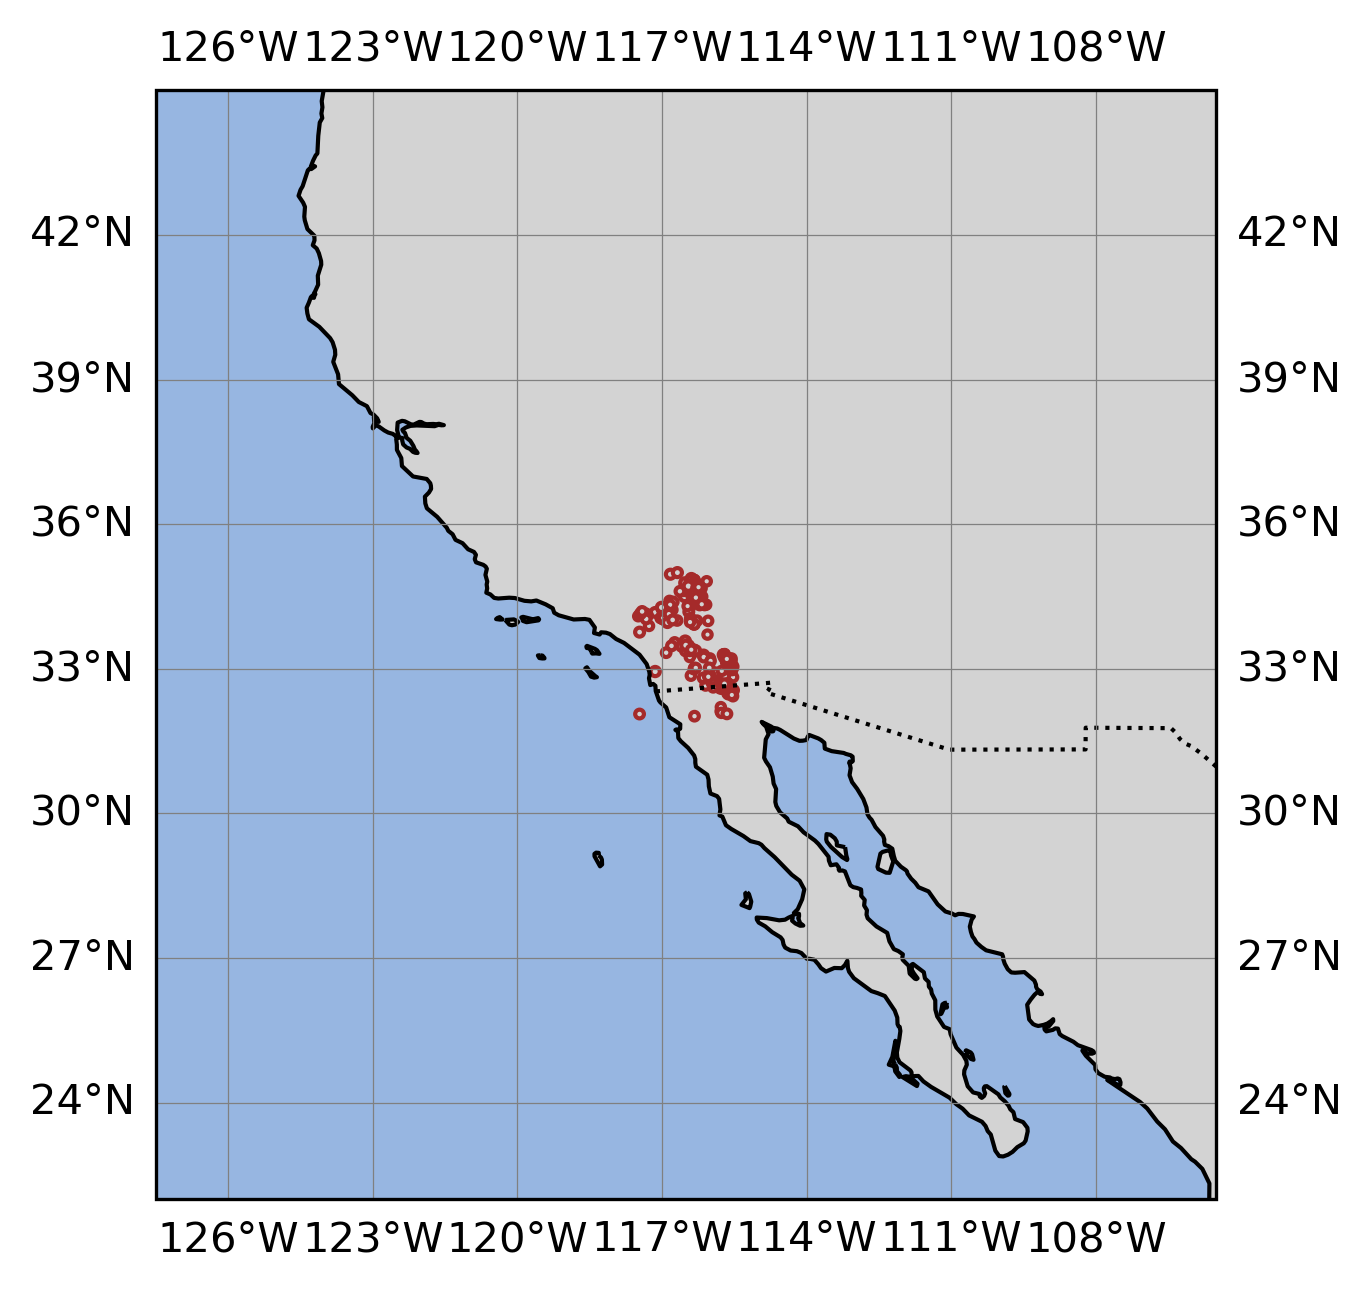

In [6]:
extent_buffer = 10
earthquakes.plot_map(extent=[-117.5 - extent_buffer, -115.5 + extent_buffer, 32 - extent_buffer, 35 + extent_buffer ])

In [19]:
folder_names = os.listdir(data_dir/"data")
folder_names = [f for f in folder_names if os.path.isdir(data_dir/"data"/f)]
total_number_of_samples = len(folder_names)
analysis_metadata = metadata["analysis_metadata"]

In [ ]:
number_of_samples = min([len(folder_names),5])
random_sample_indices = np.random.randint(0, total_number_of_samples, number_of_samples)

fig, ax = plt.subplots(number_of_samples, 1, sharex=True, figsize=(4, number_of_samples))

i = 0
while True:
    
    try: 
        # load these files
        amplitude = np.load(data_dir/"data"/folder_names[i]/"amplitude.npy")
        times = np.load(data_dir/"data"/folder_names[i]/"times.npy")
        
        
        # plot the waveform
        ax[i].plot(times, amplitude,lw=0.5)
        
        ax[i].set(
            yticks=[],
            xticks=[],
        )
        
        ax[i].axvspan(
            analysis_metadata['analysis_metadata']['pre_buffer'],
            analysis_metadata['analysis_metadata']['pre_buffer'] + analysis_metadata['analysis_metadata']['event_time_window'],
            facecolor='r',
            alpha=0.1,
        )
        
        ax[i].axvline(
            analysis_metadata['analysis_metadata']['pre_buffer'],
            lw=0.5,
            c='r',
        )
        
        # ax[i].set(
        #     xlim=[
        #         analysis_metadata['analysis_metadata']['pre_buffer'] - analysis_metadata['analysis_metadata']['mid_buffer'], 
        #         analysis_metadata['analysis_metadata']['pre_buffer'] + analysis_metadata['analysis_metadata']['event_time_window'] + analysis_metadata['analysis_metadata']['mid_buffer']
        #     ]
        # )
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        
        if i != number_of_samples - 1:
            ax[i].spines['bottom'].set_visible(False)
        
    except:
        # Handle exceptions by printing the error and continuing with the next index
        print(f"Error processing folder {folder_names[i]}: No amplitude file")
        i += 1
        if i >= number_of_samples:
            break
    
    
    

Error processing folder 1999-10-16_10-57-08: No amplitude file


In [26]:

a_max_minus = []
a_max_plus = []

for i in range(len(folder_names)):
    
    # os.path.listdir(data_dir/"data"/folder_names[i])
    if "amplitude.npy" in os.listdir(data_dir/"data"/folder_names[i]):

        # load these files
        amplitude = np.load(data_dir / "data" / folder_names[i] / "amplitude.npy")
        times = np.load(data_dir / "data" / folder_names[i] / "times.npy")

        if not len(amplitude):
            continue
        
        expected_signal_time = (
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        )
            
        if times.max() > expected_signal_time*0.9:
            amplitudes.append(amplitude)
            times.append(time)
        
        minus_time_range = [
            analysis_metadata["pre_buffer"],
            analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
        ]
        

        plus_time_range = [
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"],
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"],
        ]

        a_minus = amplitude[(times >= minus_time_range[0]) & (times <= minus_time_range[1])]
        a_plus = amplitude[(times >= plus_time_range[0]) & (times <= plus_time_range[1])]

        a_max_minus.append(np.max(a_minus))
        a_max_plus.append(np.max(a_plus))

ValueError: zero-size array to reduction operation maximum which has no identity

In [41]:
plus_time_range

[640.0000000000001, 4240.0]

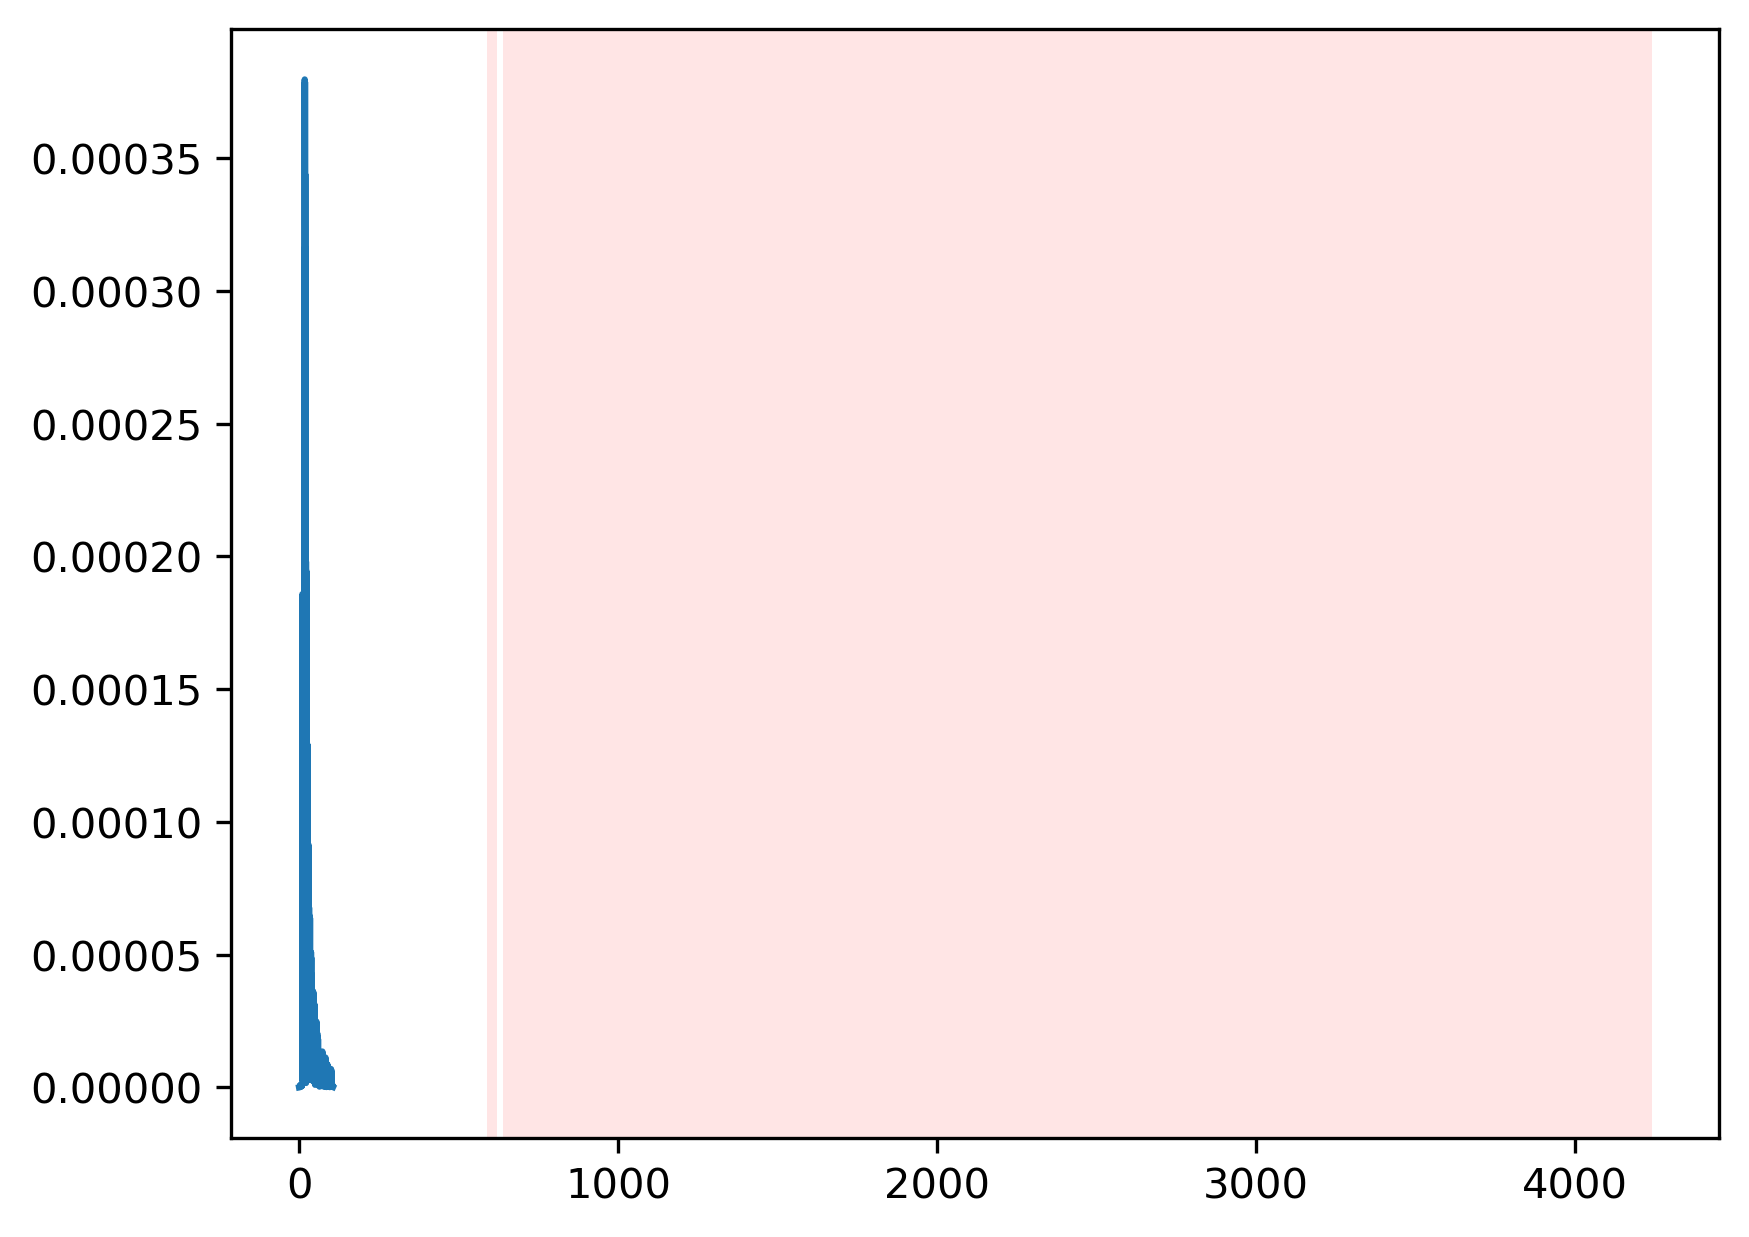

In [42]:
fig, ax = plt.subplots()
ax.plot(times, amplitude)
ax.axvspan(minus_time_range[0], minus_time_range[1], facecolor='r', alpha=0.1)
ax.axvspan(plus_time_range[0], plus_time_range[1], facecolor='r', alpha=0.1)


In [37]:
len(amplitude)

26625

In [ ]:
sum((times >= minus_time_range[0]) & (times <= minus_time_range[1]))

array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 1.06488e+02,
       1.06492e+02, 1.06496e+02], shape=(26625,))